# Importing modules

In [1]:
from preset_source_models import ModelSourceMaker
from simulate_ALMA_observations import run_simalma, extract_MS_data

# Generating a model source using presets

In [ ]:
# Create a ModelSourceMaker instance
# factory = ModelSourceMaker(
#     fov_arcsec=100,
#     npix=128,
#     ra_dec_center="05h35m17.3s -05d23m28s"
# )

In [ ]:
# Generate and save all model images
########################################################################################################################
# factory.generate_and_save("flat_disk", factory.flat_disk(radius_arcsec=30, intensity=2.0))
# factory.generate_and_save("gaussian", factory.gaussian(fwhm_arcsec=20, amplitude=1.0))
# factory.generate_and_save("elliptical_disk", factory.elliptical_disk(major_arcsec=40, minor_arcsec=20, angle_deg=45))
# factory.generate_and_save("hollow_ring", factory.hollow_ring(inner_radius_arcsec=20, outer_radius_arcsec=40))
# factory.generate_and_save("concentric_rings", factory.concentric_rings(radii_arcsec=[15, 30, 45], widths_arcsec=[2, 5, 7], intensities=[1.0, 0.5, 0.3]))
# factory.generate_and_save("elliptical_gaussian", factory.elliptical_gaussian(major_fwhm_arcsec=30, minor_fwhm_arcsec=20, angle_deg=30, amplitude=1.0))
# factory.generate_and_save("spiral_arms", factory.spiral_arms(arm_width_arcsec=5, pitch_angle_deg=20, number_of_turns=3, intensity=1.0))
# factory.generate_and_save("point_sources", factory.point_sources(source_list=[(0, 0, 1.0), (10, 10, 0.5), (-10, -10, 0.3)]))
########################################################################################################################

In [ ]:
# factory.generate_and_save("elliptical_disk_0", factory.elliptical_disk(major_arcsec=40, minor_arcsec=20, angle_deg=0))
# factory.generate_and_save("elliptical_disk_45", factory.elliptical_disk(major_arcsec=40, minor_arcsec=20, angle_deg=45))
# factory.generate_and_save("elliptical_disk_90", factory.elliptical_disk(major_arcsec=40, minor_arcsec=20, angle_deg=90))
# factory.generate_and_save("elliptical_disk_275", factory.elliptical_disk(major_arcsec=40, minor_arcsec=20, angle_deg=275))
# factory.generate_and_save("elliptical_disk_-25", factory.elliptical_disk(major_arcsec=40, minor_arcsec=20, angle_deg=-25))

In [2]:
# Generate and save a flat disk model
factory = ModelSourceMaker(
    fov_arcsec=0.1,
    npix=128,
    ra_dec_center="23h59m59.96s -34d59m59.50s"
)
factory.generate_and_save("trial_flat_disk", factory.flat_disk(radius_arcsec=0.03, intensity=2.5))

# SIMALMA

Running simalma with the following parameters:
project: trial_flat_disk
skymodel: trial_flat_disk.fits
inbright: 0.004
indirection: J2000 23h59m59.96s -34d59m59.50s
incell: 0.1arcsec
incenter: 330.076GHz
inwidth: 50MHz
mapsize:  
antennalist: ['alma.cycle5.3.cfg']
totaltime: 1800s
tptime: 0s
pwv: 0.6
overwrite: True


2025-05-29 23:48:03	WARN	simalma::::casa	saveinputs not available in casatasks, skipping saving simalma inputs
2025-05-29 23:48:03	WARN	simalma::simalma::casa	------------------------------------------------------------
2025-05-29 23:48:03	WARN	simalma::simalma::casa	Step 1: simulating 12m ALMA array
2025-05-29 23:48:03	WARN	simalma::simalma::casa	------------------------------------------------------------
2025-05-29 23:48:16	WARN	noise::CTPatchedInterp::interpolate	In caltable trial_flat_disk.alma.cycle5.3.noisy.T.cal_sim_temp (Tf Jones):
2025-05-29 23:48:16	WARN	noise::CTPatchedInterp::interpolate+	 Insufficient solution channel sampling (nchan=1) for frequency-dependent LINEAR interpolation 
2025-05-29 23:48:16	WARN	noise::CTPatchedInterp::interpolate+	 of calibration for MS spw=0; using NEAREST instead.


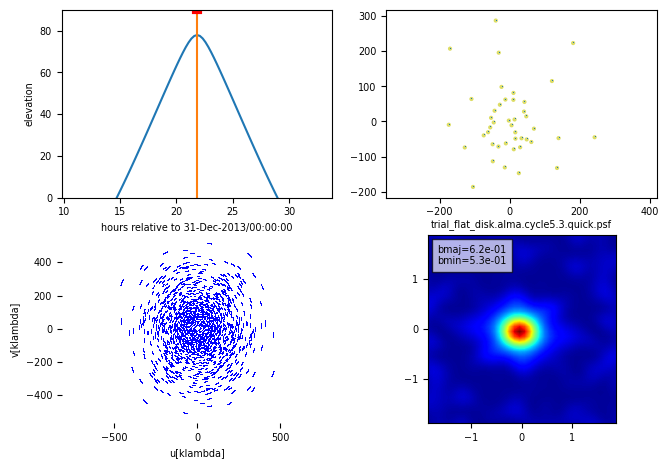

In [6]:
run_simalma(project="trial_flat_disk",
            overwrite=True,
            skymodel="trial_flat_disk.fits",
            indirection="J2000 23h59m59.96s -34d59m59.50s",
            incell="0.1arcsec",
            inbright="0.004",
            incenter="330.076GHz",
            inwidth="50MHz",
            antennalist=["alma.cycle5.3.cfg"],
            totaltime="1800s",
            mapsize=" ",
            tpnant = 0,
            tptime="0s",
            pwv=0.6,
            dryrun = False,
            image = False
            )

# Extract MS data to .npz

Number of SPWs in MS: 1
Channels per SPW: [1]
Corrs./Pols. per SPW: [2] 

Data shape: (162540,)


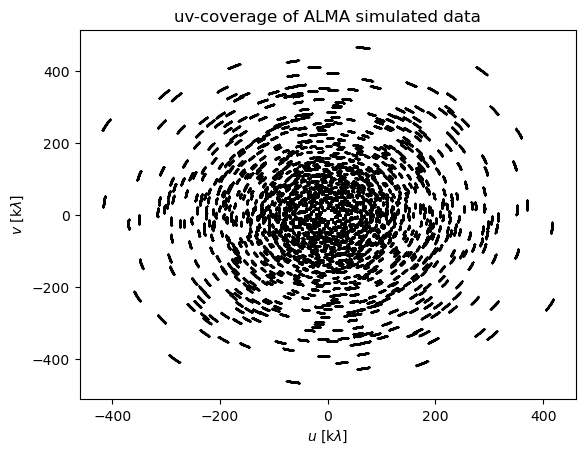

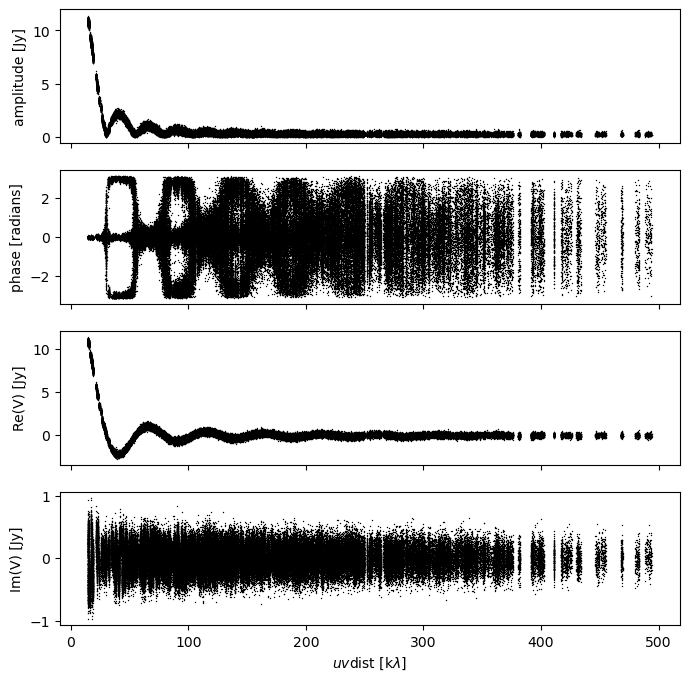

In [3]:
ms_path = "trial_flat_disk/trial_flat_disk.alma.cycle5.3.noisy.ms"
npz_file = "trial_flat_disk.npz"

_ = extract_MS_data(ms_path=ms_path, npz_file=npz_file, make_visibility_plots=True)